1) Load in the dataset https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv into a pandas dataframe

In [29]:
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert default and student to categorical variables.

In [24]:
# NOT USED
#df_default=pd.get_dummies(df['default'])
#df_student=pd.get_dummies(df['student'])
#df_final = pd.concat([df[['balance','income']],df_default, df_student],axis=1)
#df_final.head()

In [30]:
cat_features=['default', 'student']
for c in cat_features:
    df[c] = df[c].astype('category')

3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of default labeled red if yes and blue if no.

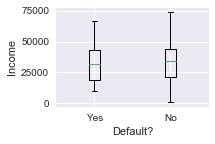

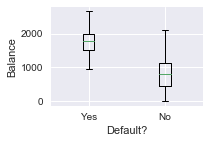

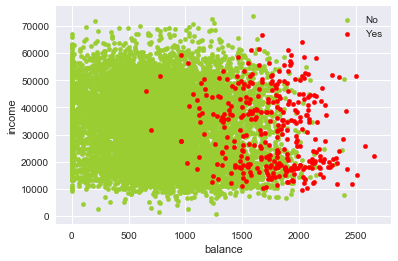

In [109]:
#f.boxplot()

ax31 = plt.subplot(221)
ax31.boxplot([df.income[df.default == 'Yes'], df.income[df.default == 'No']])
ax31.set_xticklabels(('Yes', 'No'))
ax31.set_ylabel('Income')
ax31.set_xlabel('Default?')
plt.show()

ax32 = plt.subplot(222)
ax32.boxplot([df.balance[df.default == 'Yes'], df.balance[df.default == 'No']])
ax32.set_xticklabels(('Yes', 'No'))
ax32.set_ylabel('Balance')
ax32.set_xlabel('Default?')
plt.show()

groups = df.groupby('default')
fig, ax = plt.subplots()
colors = {'Yes':'red', 'No':'yellowgreen'}
for key, group in groups:
    group.plot(ax=ax, kind='scatter', x='balance', y='income', label=key, color=colors[key])
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley on the balance and income variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [70]:
X=df[['balance', 'income']]
y=df[['default']]
size=len(df)

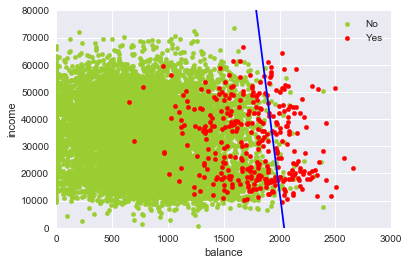

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Area under the ROC curve : 0.960534


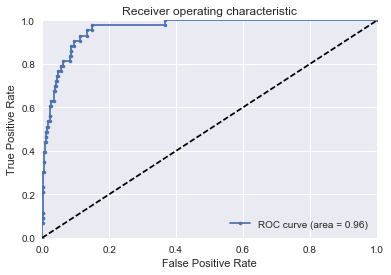

In [71]:
# plot points and Logistic Regression boundary
# below is for contour plot - NOT USED
#x_min, x_max = X.ix[:, 0].min() - .5, X.ix[:, 0].max() + .5
#y_min, y_max = X.ix[:, 1].min() - .5, X.ix[:, 1].max() + .5
#xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
 #                    np.linspace(y_min, y_max, 50))
#plt.xlim(xx.min(), xx.max())
#plt.ylim(yy.min(), yy.max())

#ax = plt.gca()
#Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
#Z = Z.reshape(xx.shape)
#cs2 = ax.contour(xx, yy, Z, levels=[.5], cmap='RdBu', alpha=.5)
#plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
#for key, group in groups:
 #   group.plot(ax=ax, kind='scatter', x='balance', y='income', label=key, color=colors[key])
#plt.show()

from sklearn.multiclass import OneVsRestClassifier
clf=OneVsRestClassifier(LogisticRegression(penalty='l1')).fit(X,y)
coef=clf.coef_
intercept=clf.intercept_
ex1=np.linspace(0,3000,3000)
ex2=-(coef[:,0]*ex1+intercept[:,0])/coef[:,1]
ax=plt.subplot(111)
for key, group in groups:
    group.plot(ax=ax, kind='scatter', x='balance', y='income', label=key, color=colors[key])
ax.plot(ex1,ex2,c='blue',label='Decision Boundary') 
ax.set_xlim([0, 3000])
ax.set_ylim([0, 80000])
plt.show()

#convert y to binary data
y['default'] = y['default'].map({'Yes': 1, 'No': 0})

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y.values.ravel(),LogisticRegression,C=0.1,penalty='l1')

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking of coefficients. How does performance improve with the added variable?

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\brian\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Area under the ROC curve : 0.959703
Area under the ROC curve : 0.960176
Area under the ROC curve : 0.960562
Area under the ROC curve : 0.960634
Area under the ROC curve : 0.960849
Area under the ROC curve : 0.961150
Area under the ROC curve : 0.961307
Area under the ROC curve : 0.961450
Area under the ROC curve : 0.961636
Area under the ROC curve : 0.961665
Area under the ROC curve : 0.961708
Area under the ROC curve : 0.961751
Area under the ROC curve : 0.961780
Area under the ROC curve : 0.961765
Area under the ROC curve : 0.961851
Area under the ROC curve : 0.961980
Area under the ROC curve : 0.961995
Area under the ROC curve : 0.962009
Area under the ROC curve : 0.962037
Area under the ROC curve : 0.962052
Area under the ROC curve : 0.962138
Area under the ROC curve : 0.962209
Area under the ROC curve : 0.962224
Area under the ROC curve : 0.962238
Area under the ROC curve : 0.962295
Area under the ROC curve : 0.962238
Area under the ROC curve : 0.962224
Area under the ROC curve : 0

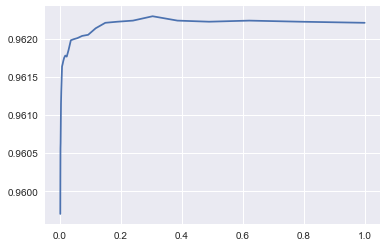

Optimal alpha : 0.303919538231


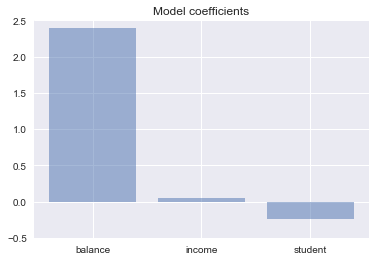

In [72]:
#make categorial variables into binary
X=df[['balance', 'income', 'student']]
X['student'] = X['student'].map({'Yes': 1, 'No': 0})
scaler = StandardScaler()
X = scaler.fit_transform(X)
y=df[['default']]
y['default'] = y['default'].map({'Yes': 1, 'No': 0})
size=len(df)

# Split the data into training/testing sets
X_train = X[0:int(size*0.8)]
X_test = X[int(size*0.8):]

# Split the targets into training/testing sets
y_train = y[0:int(size*0.8)]
y_test = y[int(size*0.8):]

alphas = np.logspace(-3,0,30)

scores = []

for alpha in alphas:
    regr = LogisticRegression(C=alpha,penalty='l2')

    # Train the model using the training sets
    regr.fit(X_train, y_train)
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha,penalty='l2')
    scores.append(roc_auc)
plt.plot(alphas,scores)
plt.show()
i_alpha_optim = np.argmax(scores)
alpha_optim = alphas[i_alpha_optim]
print("Optimal alpha : %s" % alpha_optim)

coef =  LogisticRegression(C=alpha_optim,penalty='l2').fit(X,y).coef_

objects = ('balance', 'income', 'student')
y_pos = np.arange(len(objects))
#print(y_pos, coef[0])

plt.bar(y_pos, coef[0], align='center',alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylim([-0.5, 2.5])
plt.title('Model coefficients')

Performance improves a tiny bit. ROC improves from 0.9607 to 0.9622.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

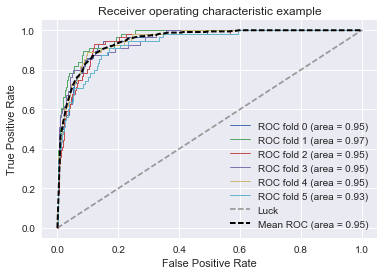

In [105]:
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

cv = StratifiedKFold(y, n_folds=6)
classifier = LogisticRegression(C=alpha_optim,penalty='l2')

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The Ridge Regression classifier performance of 0.96 from the previous problem generalizes to random folds. The ROC is essentially the same for the 5 fold validation above, with a mean ROC of 0.95.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Area under the ROC curve : 0.954498


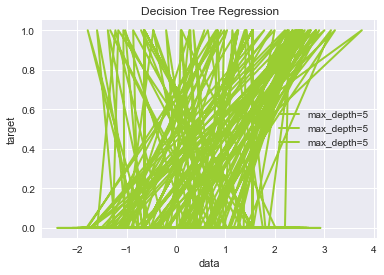

In [80]:
from sklearn.tree import DecisionTreeClassifier
X=df[['balance', 'income', 'student']]
X['student'] = X['student'].map({'Yes': 1, 'No': 0})
scaler = StandardScaler()
X = scaler.fit_transform(X)
y=df[['default']]
y['default'] = y['default'].map({'Yes': 1, 'No': 0})

# Split the data into training/testing sets
X_train = X[0:int(size*0.8)]
X_test = X[int(size*0.8):]

# Split the targets into training/testing sets
y_train = y[0:int(size*0.8)]
y_test = y[int(size*0.8):]

decTree = DecisionTreeClassifier(max_depth=5)
decTree.fit(X,y)
y_pred=decTree.predict(X_test)
y_pred

fpr, tpr, roc_auc, thresholds= generate_auc(X,y,DecisionTreeClassifier,max_depth=5)

#groups = df.groupby('default')
#fig, ax = plt.subplots()
#colors = {'Yes':'red', 'No':'blue'}
#for key, group in groups:
 #   group.plot(ax=ax, kind='scatter', x='balance', y='income', label=key, color=colors[key])

plt.figure()
#plt.scatter(X['balance'], X['income'], c="blue", label="data")
plt.plot(X_test, y_pred, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

The ROC of 0.95 is exactly the same as the mean ROC of the 5-fold cross validation using Ridge regression.

In [15]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [18]:
from __future__ import print_function

import os
import subprocess

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(decTree, feature_names=['x'])

In [2]:
import pydot
dot_data=export_graphviz(decTree, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

ModuleNotFoundError: No module named 'pydot'

8) Find the optimal decision tree depth and compute the AUC ROC.

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Area under the ROC curve : 0.747809
Area under the ROC curve : 0.904786
Area under the ROC curve : 0.951562
Area under the ROC curve : 0.950016
Area under the ROC curve : 0.932280
Area under the ROC curve : 0.783774
Optimal depth : 3


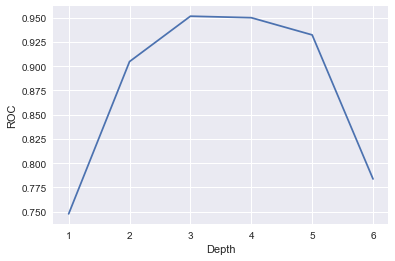

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X=df[['balance', 'income', 'student']]
X['student'] = X['student'].map({'Yes': 1, 'No': 0})
scaler = StandardScaler()
X = scaler.fit_transform(X)
y=df[['default']]
y['default'] = y['default'].map({'Yes': 1, 'No': 0})

train_errors=[]
test_errors=[]
scores=[]
depths = range(1,7)
for n in depths:
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,DecisionTreeClassifier,max_depth=n)
    scores.append(roc_auc)
plt.ylabel('ROC')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]
print("Optimal depth : %s" % n_opt)

From the plot above, the optimal depth is 3. ROC at optimal depth of 3 is 0.9512.